# Addressing Training Difficulties

Some of the MRLFADS regions train better than others. Upon visual inspection, it seems that neurons with lower firing rate train less well, possibily due to the low log-likelihood penalty (since if spiking is sparse, it doesn't cost much to not predict it). To see if this is true, I calculated the correlation between the predicted firing rates of the model with a gaussian-filter-smoothed version of the data. Ideally, the they should be somewhat similar to the other. This correlation value is then plotted against the average firing rate of the neuron across batches and time, and is shown in the figure below:

In [1]:
%matplotlib inline
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display, HTML, clear_output

clear_output()

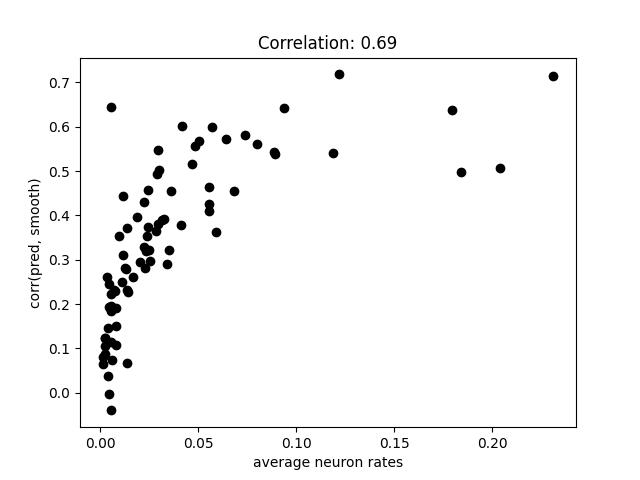

In [3]:
image = Image("../graphs/training_difficulty.png", width=650)
display(image)

This result suggests that there may indeed be some relationship between the ease of training and neurons' average firing rates. To address this, I used a Zero Inflated Poisson distribution for the model output instead of just a Poisson output.

(It also addresses passthrough!!)